(connectivity-chapter)=
# Functional connectivity

## Objectives
In the chapter on [activation maps in fMRI](fMRI_intro), we saw that this type of analysis emphasizes the notion of `functional segregation`, i.e. to what extent certain `brain regions` are involved specifically by a certain category of `cognitive processes`. But it is well known that `cognitive processes` also require some degree of **functional integration**, where different `regions` of the `brain` interact together to perform a `task`. This notion of `integration` leads us to conceive of the `brain` as a `network`, or even a `graph`, which describes the **functional connectivity** between `regions` of the `brain`. This chapter introduces basic concepts used to study `brain connectivity` using `fMRI`.

```{figure} ../../../static/neuroscience/brain-graph-fig.png
---
width: 400px
name: brain-graph-fig
---
`Average functional connectivity` graph on the `ADHD-200` `dataset`. Each `node` in the `graph` represents a `brain region`, and the `connections` represent the `average functional connectivity` on the `ADHD-200` {cite:p}`milham_adhd-200_2012` dataset, after `thresholding`. The `color scale` and `node` `size` represent the `number of connections` (`degree`) associated with each `node`. The `graph` is generated using the [gephi](https://gephi.org/) library. The figure is taken from {cite:p}`bellec_neuro_2017`, licensed under CC-BY.
```

The specific `objectives` of the chapter are to:
* Understand the definition of **functional connectivity**.
* Understand the distinction between **intrinsic** and **evoked** activity.
* Understand the notion of **functional network**.
* Know the **main idle networks**.


## Functional connectivity cards

Downloaded 72146944 of 72402326 bytes (99.6%,    0.2s remaining) ...done. (55 seconds, 0 min)
Extracting data from /Users/peerherholz/nilearn_data/adhd/f45a50254e86444511e546e90a094454/adhd40_0027011.tgz..... done.


Downloaded 71081984 of 76184603 bytes (93.3%,    1.0s remaining) ...done. (16 seconds, 0 min)
Extracting data from /Users/peerherholz/nilearn_data/adhd/f45a50254e86444511e546e90a094454/adhd40_0027018.tgz..... done.


Downloaded 68632576 of 70074120 bytes (97.9%,    0.3s remaining) ...done. (15 seconds, 0 min)
Extracting data from /Users/peerherholz/nilearn_data/adhd/f45a50254e86444511e546e90a094454/adhd40_0027034.tgz..... done.


Downloaded 64921600 of 69291635 bytes (93.7%,    2.8s remaining) ...done. (43 seconds, 0 min)
Extracting data from /Users/peerherholz/nilearn_data/adhd/f45a50254e86444511e546e90a094454/adhd40_0027037.tgz..... done.


Time series with shape (261, 122) (# time points, # parcels))
Time series with shape (261, 76297) (# time points, # voxels))


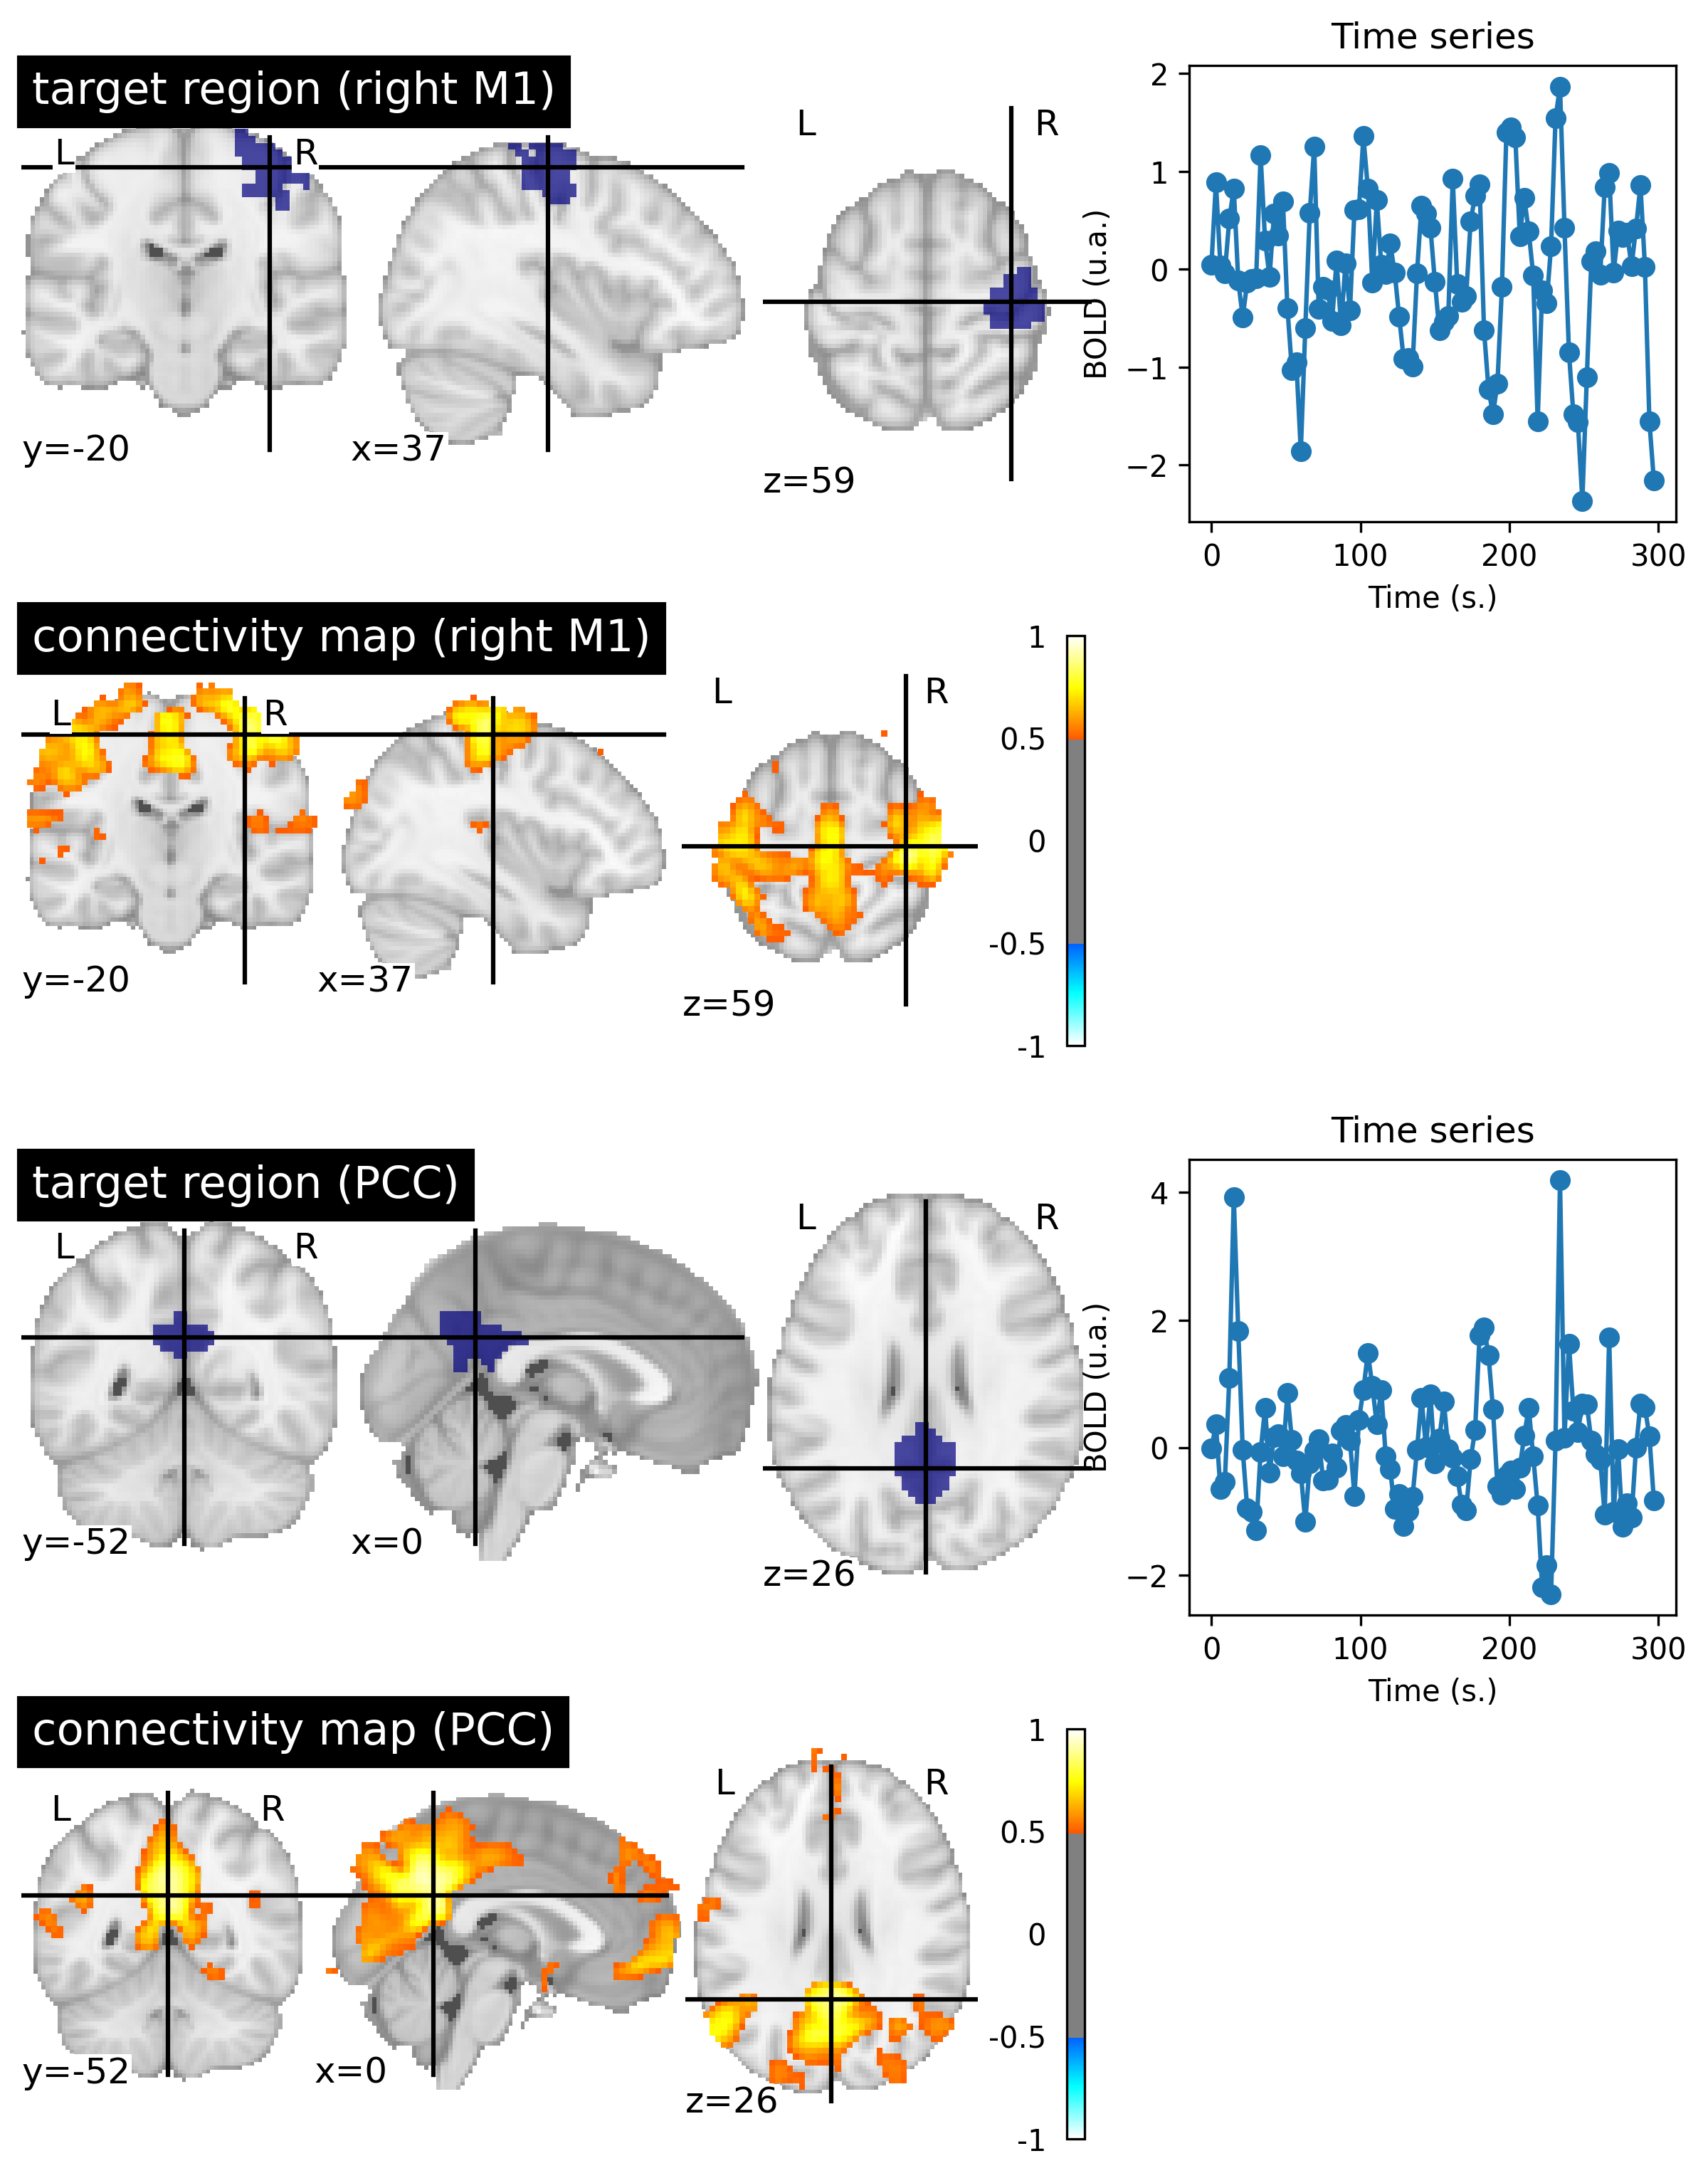

In [4]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.image import math_img
from nilearn import plotting, input_data
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets # Fetch data using nilearn
from nilearn.input_data import NiftiMasker

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Initialize the figure
fig = plt.figure(figsize=(10, 13), dpi=300)

# Import data
basc = datasets.fetch_atlas_basc_multiscale_2015() # the BASC multiscale atlas
adhd = datasets.fetch_adhd(n_subjects=10)          # ADHD200 preprocessed data (Athena pipeline)\

# Pre-processing parameters
num_data = 6
fwhm = 8
high_pass = 0.01
high_variance_confounds = False
time_samp = range(0, 100)

# Extract the signal by plot for a functional atlas (BASC)
masker = input_data.NiftiLabelsMasker(
                                      basc['scale122'],
                                      resampling_target="data",
                                      high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      memory_level=1,
                                      smoothing_fwhm=fwhm).fit()
tseries = masker.transform(adhd.func[num_data])
print(f"Time series with shape {tseries.shape} (# time points, # parcels))")

# Load data by voxel
masker_voxel = input_data.NiftiMasker(high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      smoothing_fwhm=fwhm
                                     ).fit(adhd.func[num_data])
tseries_voxel = masker_voxel.transform(adhd.func[num_data])
print(f"Time series with shape {tseries_voxel.shape} (# time points, # voxels))")

# Show a parcel
ax_plot = plt.subplot2grid((4, 3), (0, 0), colspan=2)
num_parcel = 73
plotting.plot_roi(math_img(f'img == {num_parcel}', img=basc['scale122']),
                  threshold=0.5,
                  axes=ax_plot,
                  vmax=1,
                  title="target region (right M1)")

# plot the time series of a region
ax_plot = plt.subplot2grid((4, 3), (0, 2), colspan=1)
time = np.linspace(0, 3 * (tseries.shape[0]-1), tseries.shape[0])
plt.plot(time[time_samp], tseries[time_samp, :][:, num_parcel], 'o-'),
plt.xlabel('Time (s.)'),
plt.ylabel('BOLD (u.a.)')
plt.title('Time series')

# connectivity map
ax_plot = plt.subplot2grid((4, 3), (1, 0), colspan=2)
seed_to_voxel_correlations = (np.dot(tseries_voxel.T, tseries[:, num_parcel-1]) / tseries.shape[0])# Show the connectivity map
conn_map = masker_voxel.inverse_transform(seed_to_voxel_correlations.T)
plotting.plot_stat_map(conn_map,
                       threshold=0.5,
                       vmax=1,
                       axes=ax_plot,
                       cut_coords=(37, -20, 59),
                       title="connectivity map (right M1)")

# Show a parcel
num_parcel = 17
ax_plot = plt.subplot2grid((4, 3), (2, 0), colspan=2)
plotting.plot_roi(math_img(f'img == {num_parcel}', img=basc['scale122']),
                  threshold=0.5,
                  vmax=1,
                  axes=ax_plot,
                  title="target region (PCC)")

# plot the time series of a region
ax_plot = plt.subplot2grid((4, 3), (2, 2), colspan=1)
time = np.linspace(0, 3 * (tseries.shape[0]-1), tseries.shape[0])
plt.plot(time[time_samp], tseries[time_samp, :][:, num_parcel], 'o-'),
plt.xlabel('Time (s.)'),
plt.ylabel('BOLD (u.a.)')
plt.title('Time series')


# connectivity map
ax_plot = plt.subplot2grid((4, 3), (3, 0), colspan=2)
seed_to_voxel_correlations = (np.dot(tseries_voxel.T, tseries[:, num_parcel-1]) / tseries.shape[0])# Show the connectivity map
conn_map = masker_voxel.inverse_transform(seed_to_voxel_correlations.T)
plotting.plot_stat_map(conn_map,
                       threshold=0.5,
                       cut_coords=(0, -52, 26),
                       vmax=1,
                       axes=ax_plot,
                       title="connectivity map (PCC)")

from myst_nb import glue
glue("fcmri-map-fig", fig, display=False)

```{glue:figure} fcmri-map-fig
:figwidth: 600px
:name: fcmri-map-fig
:align: center
`Resting state` `connectivity maps` generated from `fMRI` `data` of an `individual` from the `ADHD-200 dataset` {cite:p}`milham_adhd-200_2012`. For each `map`, the `target region` used as well as the first five minutes of `BOLD` `activity` associated with the `target region` are shown. This figure is generated by python code using the [nilearn](https://nilearn.github.io/) library (click on + to see the code), and is distributed under CC-BY license.
```

Before talking about `functional connectivity`, let's revisit the concept of `activation maps` in `fMRI`. As we saw {ref}`<activation-section>`, an `activation map` is generated by comparing the `BOLD` `fluctuations` in a given `region` of the `brain` with a `prediction` of the `brain` `response` associated with a `task`. In a simplified way, the `activation map` shows us the `correlation` between the expected `activity` (based on the `experimental paradigm` and a `hemodynamic response function`) and the `activity` measured at each `voxel`.

A `connectivity map` is somewhat of the same logic. But instead of looking at the expected `response` to a `task`, we're going to look at the `activity` of a particular `region` of the `brain`, called the **target region**. We will then measure the `correlation` between the `time course` of each `voxel` in the `brain` and the `time course` of the `target region`. We will obtain a **functional connectivity map** which shows us which `regions` of the `brain` have a highly `correlated` (or `synchronous`) `activity` with the `target region`.

```{admonition} Correlation measurement
:class: tip
:name: correlation

The [correlation](https://en.wikipedia.org/wiki/Correlation) between two `time series` is a measure that (usually) varies between `-1` and `1`. If the `two series` are identical (at their `mean` and `variance`), the `correlation` is `1`. If the `two series` are `statistically independent`, the `correlation` is close to `zero`. If the `two series` mirror each other, the `correlation` is `-1`.
```
***Functional connectivity*** is a relatively generic term used to describe a set of techniques for analyzing `spatial patterns` of `brain activity` {cite:p}`fox_spontaneous_2007`. Fox and Raischle (2007) propose that the simplest technique to conduct this kind of analysis is indeed to extract the `BOLD` `time course` of a **target region** and determine its `correlation` with the remaining `voxels`. More sophisticated techniques have been developed to overcome the limitations of this `modeling`. They will be discussed at the end of this chapter.

The concept of a `functional map` was introduced by Biswal and colleagues (1995) {cite:p}`biswal_functional_1995`, using a `target` in the `right primary sensorimotor cortex`. This `target region` had been obtained with an `activation map` and a `motor task`. Biswal and colleagues then came up with the idea of observing `BOLD` `fluctuations` in a **resting** condition, in the absence of an `experimental task`. This `map` reveals a `distributed set` of `regions` (see {numref}`fcmri-map-fig`, `target M1 right`), which includes the `left sensorimotor cortex`, but also the `supplementary motor area`, the `premotor cortex`, and other `regions` known for their involvement in the **motor network**. This study initially generated a great deal of skepticism, on the grounds that these `correlated functional activity patterns` could have reflected `heart` or `breath` `confounds`.

```{admonition} Slow fluctuations
:class: tip
:name: slow-fluctuations
Another key observation by {cite:p}`biswal_functional_1995` is that the `resting` `BOLD` `signal` is dominated by `slow fluctuations`, with bursts of `activity` lasting `20-30 seconds` , clearly visible in the {numref}`fcmri-map-fig`. More specifically, the `BOLD` `signal` `spectrum` at `rest` is dominated by `frequencies` below `0.08 Hz`, and even `0.03-0.05 Hz`.
```
The credibility of `resting connectivity maps` was enhanced when different research groups were able to identify other `networks` using different `target regions`, including the `visual network` and the `auditory network`. But it was the study by Greicius and collaborators, in 2003 {cite:p}`greicius_functional_2003`, that sparked enormous interest in `resting connectivity maps` using a `target region` in the `posterior cingulate cortex` (`PCC`) to identify a `network` that had not yet been identified: the **default mode network** (see {refnum}`fcmri-map-fig`, `PCC target`). We will discuss in the next section the origins of this `network`, and how it can help us understand what `resting state connectivity` measures. It is also important to mention that the work of Shmuel and colleagues (2008) {cite:p}`shmuel_neuronal_2008` demonstrated that `resting state` `BOLD` `activity` `correlates` with `spontaneous fluctuations` of `neural activity` in the `visual cortex` of a anesthetized `macaque`, demonstrating that `functional connectivity` at least partially reflects the `synchrony` of `neuronal activity`, and not simply `physiological noise` (`cardiac`, `respiration`).

```{admonition} Intra- and inter-individual variability
:class: caution attention
:name: fcmri-map-warning
The {numref}`fcmri-map-fig` can make `connectivity networks` appear extremely `stable`. In reality, `connectivity maps` `vary` a lot over `time`, ie by looking at different `windows of activity` for the same `individual`, and also between `individuals`. Indeed, the `coordinates` of a `target region` may be partially inaccurate even if the `images` are registered. Characterizing the `intra-` and `inter-individual` `variability` of `connectivity maps` is an active area of research.
```
## The default mode network

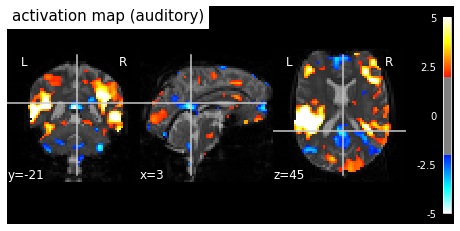

In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import datasets
from nilearn.image import math_img
from nilearn import image
from nilearn import masking
from nilearn.glm.first_level import FirstLevelModel
from nilearn import input_data
from nilearn.input_data import NiftiLabelsMasker
from nilearn.input_data import NiftiMasker
from nilearn import plotting

# Initialize the figure
fig = plt.figure(figsize=(8, 4))

# load fMRI data
subject_data = datasets.fetch_spm_auditory()
fmri_img = image.concat_imgs(subject_data.func)

# Make an average
mean_img = image.mean_img(fmri_img)
mask = masking.compute_epi_mask(mean_img)

# Clean and smooth data
fmri_img = image.clean_img(fmri_img, high_pass=0.01, t_r=7, standardize=False)
fmri_img = image.smooth_img(fmri_img, 8.)

# load events
events = pd.read_table(subject_data['events'])

# Fit model
fmri_glm = FirstLevelModel(t_r=7,
                           drift_model='cosine',
                           signal_scaling=False,
                           mask_img=mask,                           
                           minimize_memory=False)

fmri_glm = fmri_glm.fit(fmri_img, events)

# Extract activation clusters
z_map = fmri_glm.compute_contrast('active - rest')

# plot activation map
ax_plot = plt.gca()
plotting.plot_stat_map(
        z_map, threshold=2, vmax=5, figure=fig,
        axes=ax_plot, colorbar=True, cut_coords=(3., -21, 45), bg_img=mean_img, title='activation map (auditory)')

# Glue the figure
from myst_nb import glue
glue("deactivation-fig", fig, display=False)

```{glue:figure} deactivation-fig
:figwidth: 600px
:name: deactivation-fig
:align: center
Individual `activation map` in an `auditory paradigm` ([spm_auditory dataset](https://www.fil.ion.ucl.ac.uk/spm/data/auditory/)). The `significance level` is liberally selected (`|z|>2`). Moderate `deactivation` is identified in different `regions` of the `brain`, including the `posterior cingulate cortex` (`PCC`) and the `medial prefrontal cortex` (`mPFC`). The `PCC` and `mPFC` are key `regions` of the `default mode network`. This figure is generated by python code using the [nilearn](https://nilearn.github.io/) library (click on + to see the code), and is distributed under CC-BY license.
```

The discovery of the `default mode` was carried out through the study of `activation`, in `PET`. In 1997, Shulman and colleagues {cite:p}`shulman_common_1997` combined 9 `PET` studies that used the same `"resting"` `control condition` (consisting of `passively` looking at `visual stimuli`), and varied `cognitively demanding tasks` . The authors demonstrate that a set of `regions` are `systematically` more `involved` at `rest` than during the `task`, including in particular the `posterior cingulate cortex` (`PCC`). In 2001, Gusnard and Raichle {cite:p}`raichle_default_2001` build on the study by Shulman et al. to formulate the now famous "_default mode hypothesis_". There would be a number of `introspective cognitive processes` that would be consistently present in a `resting state`, and there would be a `functional network` that would support this `"default" activity`. To confirm this hypothesis, Greicius and colleagues {cite:p}`greicius_functional_2003` used an `fMRI` `resting` `connectivity map` with a `target region` in the `PCC`, and identified a `spatially` very similar `resting spontaneous activity network default mode network`, see {refnum}`fcmri-map-fig`. The `network` context of the `default mode` has since evolved, see the review by Buckner and DiNicola (2019) {cite:p}`buckner_brains_2019` for a recent review of its `neuroanatomy` and `cognitive roles`.

Time series with shape (176, 122) (# time points, # parcels))
Time series with shape (176, 71441) (# time points, # voxels))


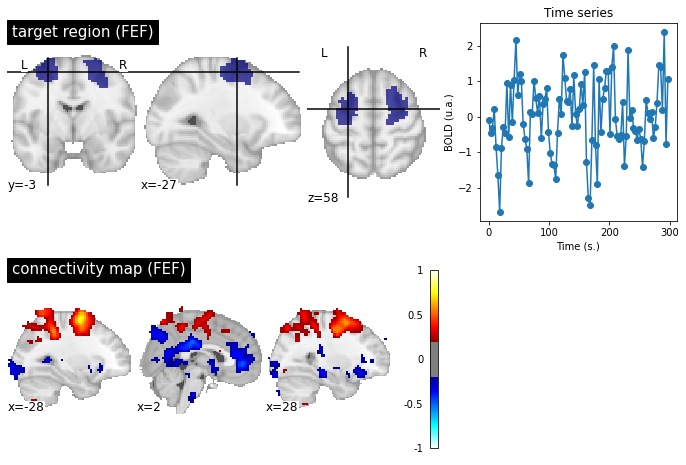

In [5]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import datasets
from nilearn.image import math_img
from nilearn import image
from nilearn import masking
from nilearn.glm.first_level import FirstLevelModel
from nilearn import input_data
from nilearn.input_data import NiftiLabelsMasker
from nilearn.input_data import NiftiMasker
from nilearn import plotting

# Initialize the figure
fig = plt.figure(figsize=(12,8))

# Import data
basc = datasets.fetch_atlas_basc_multiscale_2015() # the BASC multiscale atlas
adhd = datasets.fetch_adhd(n_subjects=10)          # ADHD200 preprocessed data (Athena pipeline)\

# Pre-processing parameters
num_data = 1
fwhm = 8
high_pass = 0.01
high_variance_confounds = False
time_samp = range(0, 100)

# Extract the signal for a functional atlas (BASC)
masker = input_data.NiftiLabelsMasker(
                                      basc['scale122'],
                                      resampling_target="data",
                                      high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      memory_level=1,
                                      smoothing_fwhm=fwhm).fit()
tseries = masker.transform(adhd.func[num_data])
print(f"Time series with shape {tseries.shape} (# time points, # parcels))")

# Load data by voxel
masker_voxel = input_data.NiftiMasker(high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      smoothing_fwhm=fwhm
                                     ).fit(adhd.func[num_data])
tseries_voxel = masker_voxel.transform(adhd.func[num_data])
print(f"Time series with shape {tseries_voxel.shape} (# time points, # voxels))")

# Applies global signal correction
from nilearn.signal import clean as signal_clean
gb_signal = signal_clean(
                        tseries.mean(axis=1).reshape([tseries.shape[0], 1]),
                        high_pass=high_pass,
                        t_r=3,
                        standardize=True)
tseries = masker.transform(adhd.func[num_data], confounds=gb_signal)
tseries_voxel = masker_voxel.transform(adhd.func[num_data], confounds=gb_signal)

# Show a parcel
ax_plot = plt.subplot2grid((2, 3), (0, 0), colspan=2)
num_parcel = 113
plotting.plot_roi(math_img(f'img == {num_parcel}', img=basc['scale122']),
                  threshold=0.5,
                  axes=ax_plot,
                  vmax=1,
                  title="target region (FEF)")

# plot la série temporelle d'une région
ax_plot = plt.subplot2grid((2, 3), (0, 2), colspan=1)
time = np.linspace(0, 3 * (tseries.shape[0]-1), tseries.shape[0])
plt.plot(time[time_samp], tseries[time_samp, :][:, num_parcel], 'o-'),
plt.xlabel('Time (s.)'),
plt.ylabel('BOLD (u.a.)')
plt.title('Time series')

# connectivity map
ax_plot = plt.subplot2grid((2, 3), (1, 0), colspan=2)
seed_to_voxel_correlations = (np.dot(tseries_voxel.T, tseries[:, num_parcel-1]) / tseries.shape[0])# Show the connectivity map
conn_map = masker_voxel.inverse_transform(seed_to_voxel_correlations.T)
plotting.plot_stat_map(conn_map,
                       threshold=0.2,
                       vmax=1,
                       axes=ax_plot,
                       cut_coords=(-28, 2, 28),
                       display_mode = 'x',
                       title="connectivity map (FEF)")

# Glue the figure
from myst_nb import glue
glue("negative-DMN-fig", fig, display=False)

```{glue:figure} negative-DMN-fig
:figwidth: 600px
:name: negative-DMN-fig
:align: center
 A `target region` is selected at the `"frontal eye field"` (`FEF`) level, to generate a `connectivity map` on a `participant` from the `ADHD-200` {cite:p}`milham_adhd-200_2012` dataset. The `significance level` is liberally selected (`|r|>0.2`). In addition to the `dorsal attentional network` associated with the `FEF`, the `connectivity map` highlights a `negative correlation` with the `PCC` and the `anterior cingulate cortex` (`ACC`). The `ACC` and `PCC` are key `regions` of the `default mode network`. This figure is generated by python code using the [nilearn](https://nilearn.github.io/) library (click on + to see the code), and is distributed under CC-BY license.
```
The `default mode network` is not the only one that can be identified at `rest`. We have already seen the `sensorimotor network` which was first identified by Biswal et al. {cite:p}`biswal_functional_1995`. Another `network` commonly examined in the literature is the `dorsal attentional network` (`DAN`), which notably includes the `superior intraparietal sulci` (`IPS`) and the `frontal eye fields` (`FEF`). The `DAN` is often identified as `activated` in `experiments` using a `cognitively demanding` `fMRI task`, and is sometimes referred to as the `"task positive network"` - even though it is not `positively` engaged by all `tasks`. In 2005, Fox and colleagues {cite:p}`fox_human_2005` notice a `negative correlation` between `DAN` and the `default mode network`. This analysis reinforces the notion of `spontaneous` transitions between a `mental state` directed towards `external stimuli`, and an `introspective state`, reflecting the competition between two distributed `networks`.

```{admonition} Global signal regression controversies
:class: caution attention
:name: negative-r-warning
The `negative correlations` of the {numref}`negative-DMN-fig` are strong only when we apply certain data `denoising` steps, and in particular the _global signal regression_. Significant controversy has arisen around the `negative connections`, as some researchers believe it to be an `artifact` related to this `preprocessing step`. Nevertheless, `negative correlations` can be observed robustly for `participants` who move very little, and whose `signal` is therefore particularly `clean`. Their `amplitude` is however low in the absence of `regression` of the overall `signal`.
```
```{admonition} Intrinsic vs Extrinsic Activity
:class: tip
:name: intrinsic-tip
`Resting networks` can be observed even in the presence of a `task`. Rather than opposing the notion of `rest` and `task`, it is common to speak of `intrinsic` and `extrinsic` `activity`. **Extrinsic activity** is the `activity` evoked by a `task`, and reflects how the environment influences `brain activity`. In contrast, **intrinsic activity** refers to `brain activity` that emerges `spontaneously`, and is `independent` of `external stimuli`. Both types of `activity` are always present, and can interact with each other.
```

## Functional networks

/Users/peerherholz/anaconda3/envs/ml-dl-synage/lib/python3.8/site-packages/nilearn/datasets/func.py:255: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  phenotypic = np.genfromtxt(phenotypic, names=True, delimiter=',',


Time series with shape (176, 122) (# time points, # parcels))


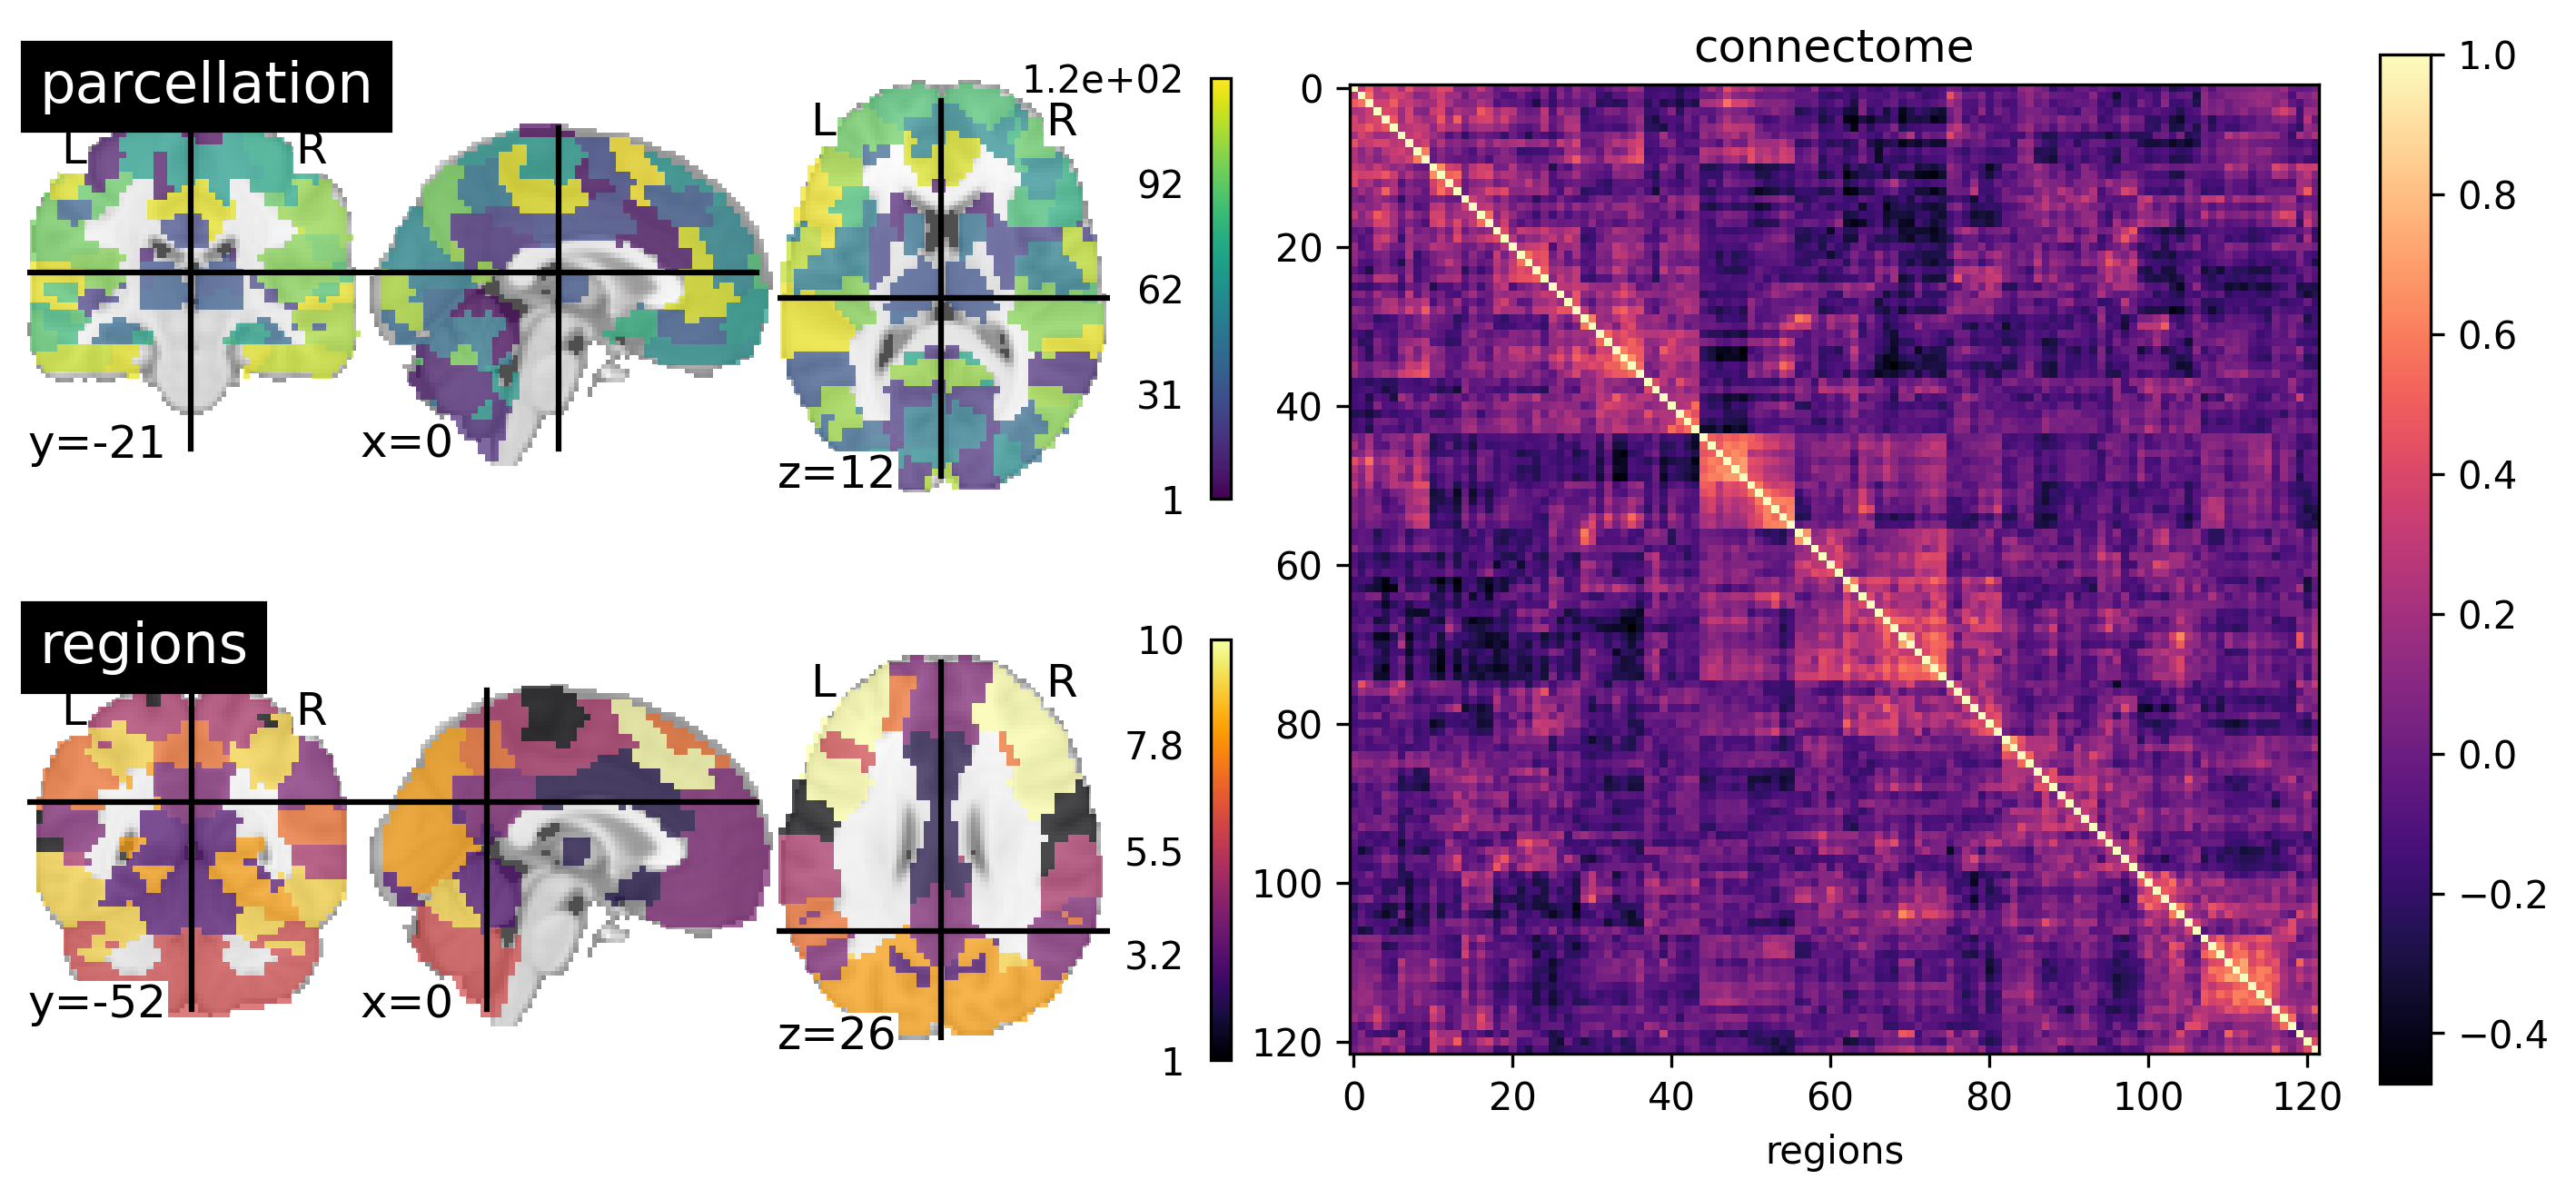

In [5]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import datasets
from nilearn.image import math_img
from nilearn import image
from nilearn import masking
from nilearn.glm.first_level import FirstLevelModel
from nilearn import input_data
from nilearn.input_data import NiftiLabelsMasker
from nilearn.input_data import NiftiMasker
from nilearn import plotting

# Initialize the figure
fig = plt.figure(figsize=(12, 5), dpi=300)

# Import data
basc = datasets.fetch_atlas_basc_multiscale_2015() # the BASC multiscale atlas
adhd = datasets.fetch_adhd(n_subjects=10)          # ADHD200 preprocessed data (Athena pipeline)\

# Pre-processing parameters
num_data = 1
fwhm = 8
high_pass = 0.01
high_variance_confounds = False
time_samp = range(0, 100)

# Extract the signal for a functional atlas (BASC)
masker = input_data.NiftiLabelsMasker(
                                      basc['scale122'],
                                      resampling_target="data",
                                      high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      memory_level=1,
                                      smoothing_fwhm=fwhm).fit()
tseries = masker.transform(adhd.func[num_data])
print(f"Time series with shape {tseries.shape} (# time points, # parcels))")


# Applies global signal correction
from nilearn.signal import clean as signal_clean
gb_signal = signal_clean(
                        tseries.mean(axis=1).reshape([tseries.shape[0], 1]),
                        high_pass=high_pass,
                        t_r=3,
                        standardize=True)
tseries = masker.transform(adhd.func[num_data], confounds=gb_signal)

# Affiche le template
ax_plot = plt.subplot2grid((2, 4), (0, 0), colspan=2)
plotting.plot_roi(basc['scale122'], title="parcellation", axes=ax_plot, colorbar=True, cmap="viridis")

# We generate a connectome
from nilearn.connectome import ConnectivityMeasure
conn = np.squeeze(ConnectivityMeasure(kind='correlation').fit_transform([tseries]))

# we use scipy's hierarchical clustering implementation
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
# That's the hierarchical clustering step
hier = linkage(conn, method='average', metric='euclidean') # scipy's hierarchical clustering
# HAC proceeds by iteratively merging brain regions, which can be visualized with a tree
res = dendrogram(hier, get_leaves=True, no_plot=True) # Generate a dendrogram from the hierarchy
order = res.get('leaves') # Extract the order on parcels from the dendrogram
part = np.squeeze(cut_tree(hier, n_clusters=10))

# Show the connectome
ax_plot = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
ax_plot.set_xlabel('regions')
ax_plot.set_title('connectome')
pos = ax_plot.imshow(conn[order, :][:, order], cmap='magma', interpolation='nearest')
fig.colorbar(pos, ax=ax_plot)

# Show networks
ax_plot = plt.subplot2grid((2, 4), (1, 0), colspan=2)
part_img = masker.inverse_transform(part.reshape([1, 122]) + 1) # note the sneaky shift to 1-indexing
plotting.plot_roi(part_img,
                  title="regions",
                  colorbar=True,
                  cmap="inferno",
                  axes=ax_plot,
                  cut_coords=[0, -52, 26])

# Glue the figure
from myst_nb import glue
glue("network-fig", fig, display=False)

```{glue:figure} network-fig
:figwidth: 800px
:name: network-fig
:align: center
A `functional` `brain parcellation` with `122 parcels` is shown on the left (`BASC`). In the center, we see a `matrix` where each `element` represents the `correlation` between the `activity` of two `regions`. The plots have been ordered in such a way as to highlight diagonal squares: these are `groups` of `regions` whose `activity` `correlates` strongly with each other, and little with the rest of the `brain`. `Clustering-type algorithms` make it possible to automatically detect these `groups` of `regions`, called `functional networks`. An example of `functional networks` generated with `hierarchical clustering` is shown on the right, which notably identifies the `default mode network`. This figure is generated by python code using the [nilearn](https://nilearn.github.io/) library (click on + to see the code), and is distributed under CC-BY license.
```
In the last section, we spoke several times about ***working network***, but without really defining what it is. When using a `connectivity map`, the `functional network` is the `set` of `regions` that appear in the `map`, and which are therefore `connected` to our `target region`. But this approach depends on the `target region`. Still, it's intuitive that all `connectivity maps` using `targets` in, say, the `default mode` are going to look the same. To formalize this intuition, we need to introduce the notion of `functional connectome`.

A **functional connectome** is a `matrix` that represents all the (`functional`) `connections` of the `brain`. We therefore start by selecting a `cerebral parcellation`, then we calculate the `correlation` of the `temporal activity` for all the pairs of `parcels` in the `brain`. This `correlation matrix` is of size `#plots x #plots`. By using `unsupervised learning` techniques, such as `clustering`, it is possible to identify `groups` of `regions` that are strongly `connected` to each other, and weakly `connected` to the rest of the `brain`. This is the most common definition of a `functional network`. This type of approach makes it possible to divide the `brain` into `networks`, automatically and guided by data.


Dataset created in /Users/peerherholz/nilearn_data/yeo_2011



 ...done. (2 seconds, 0 min)
Extracting data from /Users/peerherholz/nilearn_data/yeo_2011/d7a5390bfb7686fb41fa64cc2ba058d0/Yeo_JNeurophysiol11_MNI152.zip..... done.


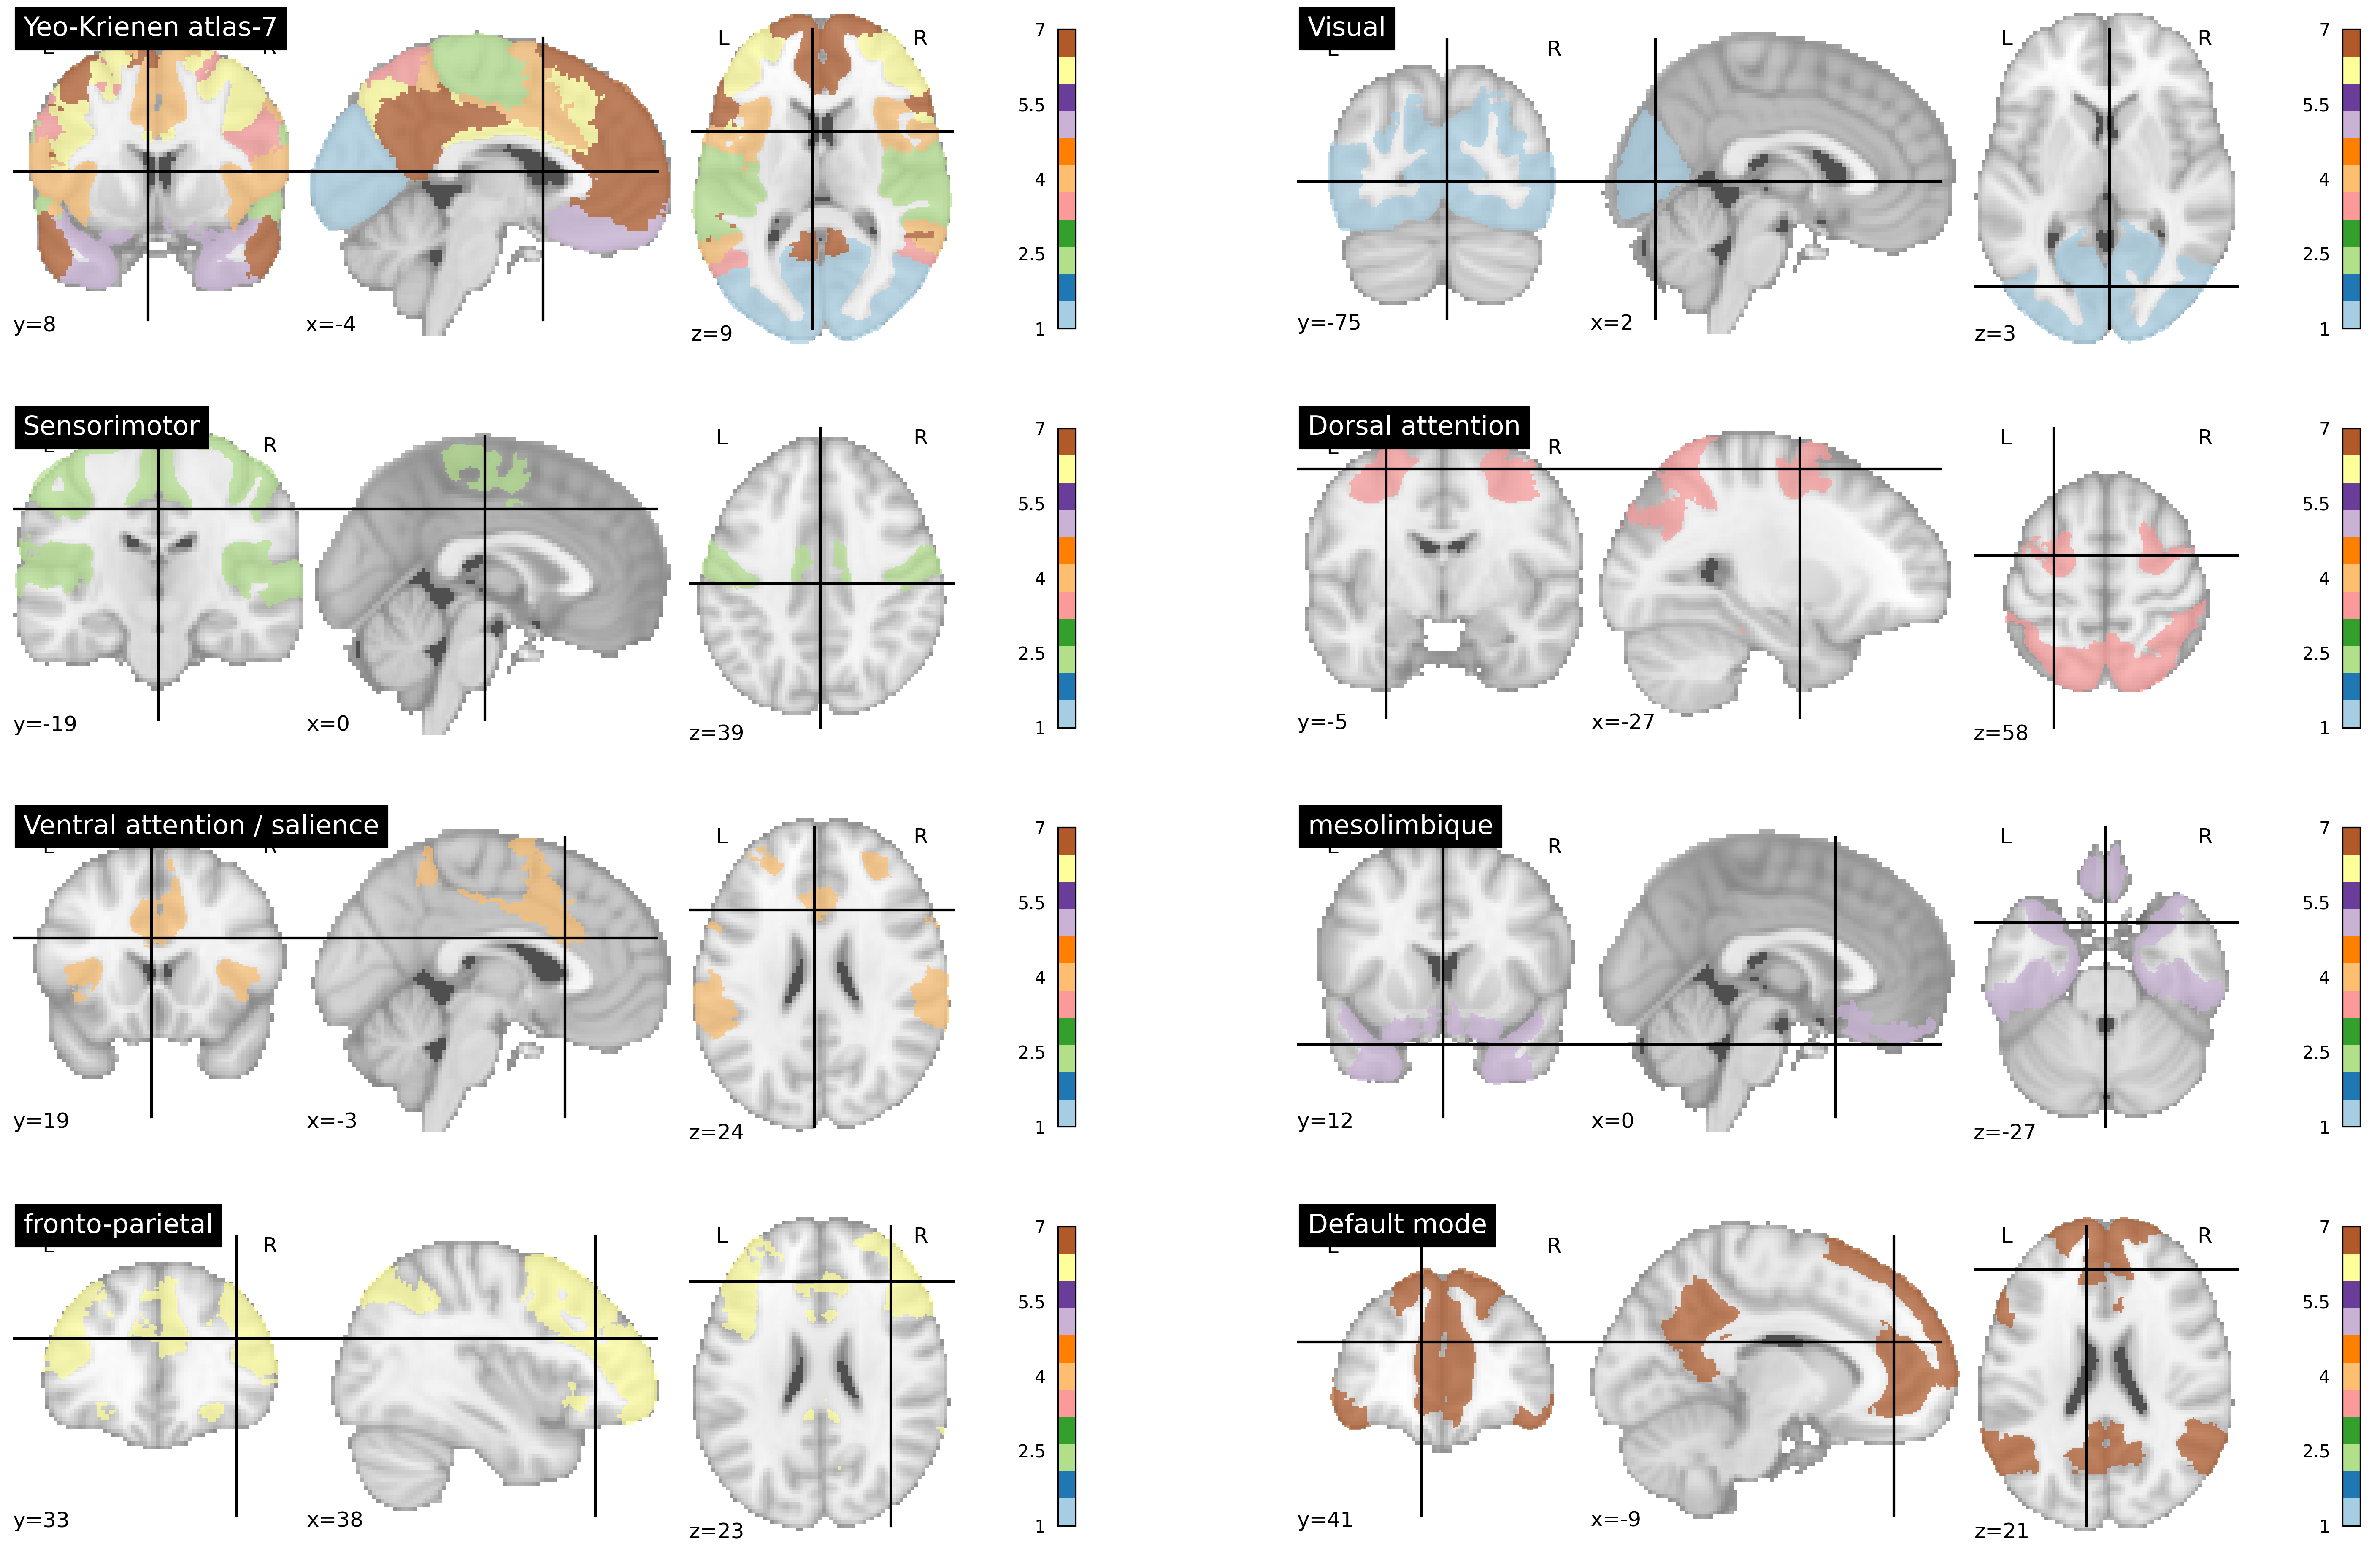

In [6]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Download data
from nilearn import datasets # Fetch data using nilearn
atlas_yeo = datasets.fetch_atlas_yeo_2011()        # the Yeo-Krienen atlas

# Initialize the figure
fig = plt.figure(figsize=(24, 16), dpi=300)

# Let's plot the Yeo-Krienen 7 clusters parcellation
from nilearn import plotting
from nilearn.image import math_img
import matplotlib.pyplot as plt
ax_plot = plt.subplot(4, 2, 1)
plotting.plot_roi(atlas_yeo.thick_7, title='Yeo-Krienen atlas-7',
                  colorbar=True, cmap='Paired', axes=ax_plot)

ax_plot = plt.subplot(4, 2, 2)
plotting.plot_roi(math_img('(img==1).astype(\'float\')', img=atlas_yeo.thick_7), title='Visual',
                  colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

ax_plot = plt.subplot(4, 2, 3)
plotting.plot_roi(math_img('2 * (img==2).astype(\'float\')', img=atlas_yeo.thick_7), title='Sensorimotor',
                  colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

ax_plot = plt.subplot(4, 2, 4)
plotting.plot_roi(math_img('3 * (img==3).astype(\'float\')', img=atlas_yeo.thick_7), title='Dorsal attention',
                  cut_coords=(-27, -5, 58), colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

ax_plot = plt.subplot(4, 2, 5)
plotting.plot_roi(math_img('4 * (img==4).astype(\'float\')', img=atlas_yeo.thick_7), title='Ventral attention / salience',
                  cut_coords=(-3, 19, 24), colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

ax_plot = plt.subplot(4, 2, 6)
plotting.plot_roi(math_img('5 * (img==5).astype(\'float\')', img=atlas_yeo.thick_7), title='mesolimbique',
                  colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

ax_plot = plt.subplot(4, 2, 7)
plotting.plot_roi(math_img('6 * (img==6).astype(\'float\')', img=atlas_yeo.thick_7), title='fronto-parietal',
                  colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

ax_plot = plt.subplot(4, 2, 8)
plotting.plot_roi(math_img('7 * (img==7).astype(\'float\')', img=atlas_yeo.thick_7), title='Default mode',
                  colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

# Glue the figure
from myst_nb import glue
glue("yeo-krienen-fig", fig, display=False)

```{glue:figure} yeo-krienen-fig
:figwidth: 800px
:name: yeo-krienen-fig
:align: center
`Atlas` of Yeo-Krienen {cite:p}`thomas_yeo_organization_2011` constructed by `clustering` analysis from `resting state` `fMRI` `data` from a large number of `participants`. The `networks` are defined at several `resolutions` in this `atlas` (`7` and `17`). Here, the division into `7` large distributed `networks` is presented. This figure is generated by python code using the [nilearn](https://nilearn.github.io/) library (click on + to see the code), and is distributed under CC-BY license.
```
There is not an exact number of `brain networks`, but rather a `hierarchy` of more or less `specialized networks`. Nevertheless, many articles have studied a division into `7` `cortical networks`. The `atlas` by Yeo, Krienen and colleagues {cite:p}`thomas_yeo_organization_2011` is widely used, and identifies seven `major networks`. Some of these `networks` have already been discussed in this chapter: `default mode`, `dorsal attentional`, `sensorimotor`. Two other `associative networks` must be added: the `frontoparietal` and the `ventral attentional` (sometimes called `salience`). There is also a `visual network`, and a `mesolimbic network` involving the `temporal pole` and the `orbitofrontal cortex`. Note that this `atlas` ignores all `subcortical structures`. The same study proposed a division into `17 sub-networks`. You can use this [interactive tool](https://simexp.github.io/multiscale_dashboard/index.html) to explore the `multiscale organization` of `functional networks` interactively, using the `MIST atlas` { quote:p}`urchs_mist_2019`.


## Conclusions
* `Functional connectivity` consists of measuring the `coherence` (`correlation`) between the `activity` of two `regions` (or `voxels`) of the `brain`.
* A `functional connectivity map` makes it possible to study the `connectivity` between a `target region` and the rest of the `brain`.
* `Functional connectivity` can be observed at `rest` (`spontaneous activity`), in the absence of an `experimental protocol`. In general, there is a superposition of `intrinsic activity` (linked to `spontaneous activity`) and `extrinsic` (linked to the `environment`).
* `Resting fMRI connectivity` played a key role in the discovery of the `default mode network`.
* A `functional network` is a group of `regions` whose `spontaneous activity` shows strong `intra-network functional connectivity`, and weak `connectivity` with the rest of the `brain`. Different `atlases` of `networks` at `rest` exist, and at different `scales`.

## References

```{bibliography}
:filter: docname in docnames
```

## Exercices
In the following we created a few exercises that aim to recap core aspects of this part of the course and thus should allow you to assess if you understood the main points. 

We start with the following “resting-state network” video:

In [6]:
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/_Iph3WW9UOU?start=18" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

```{admonition} Exercice 5.1.
:class: dropdown
“The Seventh Day” (sic), excerpt in French: 0:54 - 4:35
  1. Who represents the young man?
  2. What result does it refer to?
  3. Who represents the young woman?
  5. What outcome does it refer to?
  5. Why call this film “the seventh day” (sic)?
```

```{admonition} Exercice 5.2.
:class: dropdown
“Neuro-meteorology”: 4:48 - 5:30
1. What `networks` are we talking about here?
2. Why does he refer to the `default mode network` and the `“task-positive” network` as “Yin and yang”?
3. Are any `networks` missing in this forecast?
4. Why is turbulence in the `precuneus` (or rather the `posterior cingulate cortex`) interesting?
```

```{admonition} Exercice 5.3.
:class: dropdown
“Hardball”: 8:01 - 9:46
  1. Is it true that `spontaneous activity` is present both at `rest` and during a `task`?
  2. Is it true that `spontaneous activity` has mainly been studied in a `resting state` in `fMRI`?
  3. How is it “unpsychological” to study a `condition` of `rest`?
  4. Open question: is one of them right? Or both?
```

```{admonition} Exercice 5.4.
:class: dropdown
`Connectivity map`: true/false
  1. A `connectivity map` changes if the `target region` is changed.
  2. To define a `target region`, one must generate an `activation map`.
  3. A `functional connectivity map` has `values` between `0` and `1`.
  4. An `fMRI connectivity map` is a tool to identify the `default mode network`.
```

```{admonition} Exercice 5.5.
:class: dropdown
`Spontaneous` and `evoked activity`: true/false
  1. `Spontaneous brain activity` occurs only in a state of `rest`.
  2. `Brain activity` `evoked` by a `task` can be characterized by an `fMRI activation map`.
  3. `Spontaneous brain activity` is greater at `rest` than during a `visual task` in certain parts of the `brain`.
```

```{admonition} Exercice 5.6.
:class: dropdown
`Working networks`: true/false
  1. There are exactly `7 functional networks` in the `brain`.
  2. A `functional network` is composed of `regions` with `strong functional connectivity`.
  3. The `default mode network` can be identified with an `activation map`.
  4. `Default mode network` `regions` are `negatively correlated` with `sensorimotor network` `regions`.
```

```{admonition} Exercice 5.7
:class: dropdown
To answer this question, read the article by Shukla et al, "_Aberrant Frontostriatal Connectivity in Negative Symptoms of Schizophrenia_", published in Schizophrenia Bulletin (2019, 45(5): 1051-59) and available open access at this [ address](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6737477/). The following questions require short answers.
  * What `software` was used to `analyze` the `fMRI data`?
  * What `experimental condition` was used during the `fMRI acquisitions`?
  * What was the `spatial smoothing` setting?
  * Has the `data` been `motion corrected`? Why?
  * Did one of the two `groups` `move` more than the other?
  * What `filtering` and `noise correction` procedures have been applied?
  * In which `stereotactic space` are `group` `analyzes` performed?
  * What type of `connectivity metric` is used in the article?
```

```{admonition} Exercice 5.8.
:class: dropdown
We want to compare the `functional connectivity` between young and old people. Name three potential `confounders`, which are not related to `intrinsic neural activity`.
```